# IST 718: Big Data Analytics

- Professor: Daniel Acuna <deacuna@syr.edu>
- TAs: Tong Zeng <tozeng@syr.edu>, Priya Matnani <psmatnan@syr.edu>

## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers either from your classmates or from the internet__
- You can put the homework files anywhere you want in your http://notebook.acuna.io workspace but _do not change_ the file names. The TAs and the professor use these names to grade your homework.
- Remove or comment out code that contains `raise NotImplementedError`. This is mainly to make the `assert` statement fail if nothing is submitted.
- The tests shown in some cells (i.e., `assert` and `np.testing.` statements) are used to grade your answers. **However, the professor and TAs will use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before downloading and submitting your work through Blackboard, remember to save and press `Validate` (or go to 
`Kernel`$\rightarrow$`Restart and Run All`). 
- Good luck!

In [1]:
# Load the packages needed for this part
# create spark and sparkcontext objects
from pyspark.sql import SparkSession
import numpy as np

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

import pyspark
from pyspark.ml import feature, regression, Pipeline
from pyspark.sql import functions as fn, Row
from pyspark import sql

import matplotlib.pyplot as plt
import pandas as pd

# Part 1: Servo analysis

In this assignment, you will continue the analysis we started in class of the Servo dataset.

# Servo data analysis

```console
1. Title: Servo Data

2. Sources
   (a) Created by: Karl Ulrich (MIT) in 1986
   (b) Donor: Ross Quinlan
   (c) Date: May 1993

3. Past Usage:

   1.  Quinlan, J.R., "Learning with continuous classes", Proc. 5th Australian
       Joint Conference on AI (eds A. Adams and L. Sterling), Singapore: World
       Scientific, 1992
 
   2.  Quinlan, J.R., "Combining instance-based and model-based learning",
       Proc. ML'93 (ed P.E. Utgoff), San Mateo: Morgan Kaufmann 1993
 
       Results on 10-way cross-validation:
 
       Method			Average		Relative
       ------			 |Err|		 Error
 				-------		--------
 
       Guessing mean		  1.15		  1.00
       Instance-based		   .52		   .26
       Regression		   .86		   .49
       Model trees		   .45		   .29
       Neural nets (G. Hinton)	   .30		   .11
       Regression+instances	   .48		   .20
       Model trees+instances	   .30		   .17
       NN+instances		   .29		   .11
 
4. Relevant Information:

   Ross Quinlan:

   This data was given to me by Karl Ulrich at MIT in 1986.  I didn't 
   record his description at the time, but here's his subsequent (1992) 
   recollection:
 
     "I seem to remember that the data was from a simulation of a servo
     system involving a servo amplifier, a motor, a lead screw/nut, and a
     sliding carriage of some sort.  It may have been on of the
     translational axes of a robot on the 9th floor of the AI lab.  In any
     case, the output value is almost certainly a rise time, or the time
     required for the system to respond to a step change in a position set
     point."
 
   (Quinlan, ML'93)

   "This is an interesting collection of data provided by Karl 
    Ulrich.  It covers an extremely non-linear phenomenon - predicting the 
    rise time of a servomechanism in terms of two (continuous) gain settings
    and two (discrete) choices of mechanical linkages."

5. Number of Instances: 167

6. Number of Attributes: 4 + numeric class attribute

7. Attribute information:

   1. motor: A,B,C,D,E
   2. screw: A,B,C,D,E
   3. pgain: 3,4,5,6
   4. vgain: 1,2,3,4,5
   5. class: 0.13 to 7.10

8. Missing Attribute Values: None
```

In [2]:
# Load the data
servo_df = spark.createDataFrame(pd.read_csv('servo.data', 
            sep=',', 
            header=None,
            names=['motor', 'screw', 'pgain', 'vgain', 'rise_time']))

# 1. Explore the data

With big data, datasets can be too big to bring them into the Spark client. However, we can use the `limit` method of a dataframe to limit the number of rows to bring as a Pandas dataframe

Create a dataframe `servo_sample_df` with the first 20 rows of `servo_df`.

In [3]:
# create `servo_sample_df`
servo_sample_df = servo_df.limit(20)
servo_sample_df

DataFrame[motor: string, screw: string, pgain: bigint, vgain: bigint, rise_time: double]

In [4]:
# 2 pts - right number of rows
np.testing.assert_equal(servo_sample_df.count(), 20)

**(3 pts)** Below, transform `servo_sample_df` into a Pandas dataframe and do a scatter plot of `pgain` vs `rise_time`

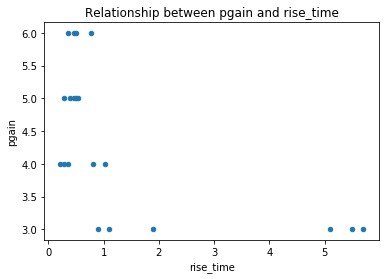

In [5]:
servo_sample_df.toPandas().plot.scatter(x='rise_time',y='pgain',title='Relationship between pgain and rise_time')

**(3 pts)** Below, transform `servo_sample_df` into a Pandas dataframe and do a scatter plot of `vgain` vs `rise_time`

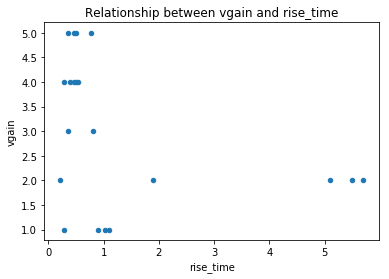

In [6]:
servo_sample_df.toPandas().plot.scatter(x='rise_time',y='vgain',title='Relationship between vgain and rise_time')

## Perform correlations between vgain-rise time, pgain-rise time, and vgain-pgain

Create a `servo_corr_df` dataframe that contains the correlations between `vgain` and `rise_time` as a column `corr_vgain_rise_time`, between `pgain` and `rise_time` as `corr_pgain_rise_time`, and `vgain` and `pgain` as `corr_vgain_pgain`.

In [7]:
corr_pgain_rise_time = servo_df.stat.corr('pgain', 'rise_time')
corr_vgain_rise_time = servo_df.stat.corr('vgain', 'rise_time')
corr_vgain_pgain = servo_df.stat.corr('vgain', 'pgain')
mylist = [(corr_vgain_rise_time,corr_pgain_rise_time, corr_vgain_pgain)]
servo_corr_df = spark.createDataFrame(mylist, ['corr_pgain_rise_time', 'corr_vgain_pgain', 'corr_vgain_rise_time'])


In [8]:
## 7 pts
np.testing.assert_equal(set(servo_corr_df.columns), 
                        {'corr_pgain_rise_time', 'corr_vgain_pgain', 'corr_vgain_rise_time'})
np.testing.assert_almost_equal(list(servo_corr_df.first().asDict().values()),
                               [-0.36438266626914595, -0.5981287119612234, 0.8122683058183874], decimal=3)

## Compute mean rise_time for different motors and screws

Create `motor_rise_time_df` with the column `motor` and `avg_rise_time`, where `avg_rise_time` is the average rise time for a motor. Sort the resulting dataframe from highest to lowest average rise time.

In [9]:
raw_value=servo_df.groupBy('motor').agg({"rise_time": "avg"}).collect()
unsorted_df= spark.createDataFrame(raw_value, ['motor', 'avg_rise_time'])
motor_rise_time_df = unsorted_df.orderBy('avg_rise_time', ascending=False)
motor_rise_time_df

DataFrame[motor: string, avg_rise_time: double]

In [10]:
# 3 pts
np.testing.assert_array_equal(np.array(motor_rise_time_df.rdd.map(lambda x: list(x.asDict().values())).collect()),
                                  [['A', '1.761110668888889'],
       ['B', '1.6819423677777776'],
       ['C', '1.2540610067500002'],
       ['E', '1.1448932081818182'],
       ['D', '0.9176125145454544']])

Create `screw_rise_time_df` with the column `screw` and `avg_rise_time` sorted from highest to lowest average rise time.

In [11]:
raw_value2=servo_df.groupBy('screw').agg({"rise_time": "avg"}).collect()
unsorted_df2= spark.createDataFrame(raw_value2, ['screw', 'avg_rise_time'])
screw_rise_time_df = unsorted_df2.orderBy('avg_rise_time', ascending=False)
screw_rise_time_df

DataFrame[screw: string, avg_rise_time: double]

In [12]:
# 3 pts
np.testing.assert_array_equal(np.array(screw_rise_time_df.rdd.map(lambda x: list(x.asDict().values())).collect()),
                                  [['A', '1.768461212142857'],
       ['B', '1.3919625091428571'],
       ['C', '1.2485862280645161'],
       ['E', '1.2256432917241378'],
       ['D', '1.1612471173333332']])

# Feature engineering

## Dummy variables for motors and screws
Create a dataframe `dummy_df` with columns `motor` and `screw` as dummy variables, and columns `vgain`, `pgain`, and `rise_time`. Use motor D and screw C as the baselines and name the dummy variables `motor_A` for motor `A` and so on. Follow a similar pattern for screw. The dataframe `dummy_df` should not contain the columns `motor` and `screw` but only their dummy variable representations. **All column types should be float or integer.**

In [13]:

dummy_df = servo_df.withColumn('motor_A',(fn.col('motor') =='A').cast('int')).\
        withColumn('motor_B',(fn.col('motor') =='B').cast('int')).\
        withColumn('motor_C',(fn.col('motor') =='C').cast('int')).\
        withColumn('motor_E',(fn.col('motor') =='E').cast('int')).\
        withColumn('screw_A',(fn.col('screw') =='A').cast('int')).\
        withColumn('screw_B',(fn.col('screw') =='B').cast('int')).\
        withColumn('screw_D',(fn.col('screw') =='D').cast('int')).\
        withColumn('screw_E',(fn.col('screw') =='E').cast('int')).drop('motor','screw')
#dummy_df.count()
dummy_df = dummy_df.select('motor_A','motor_B','motor_C','motor_E','screw_A','screw_B','screw_D',\
                           'screw_E','vgain','pgain','rise_time')

In [14]:
# 3 pts
np.testing.assert_equal(len(dummy_df.columns), 11)
np.testing.assert_equal(dummy_df.select(fn.sum('motor_A')).first()['sum(motor_A)'], 36)
np.testing.assert_equal(dummy_df.select(fn.sum('screw_A')).first()['sum(screw_A)'], 42)
np.testing.assert_equal(set(dummy_df.columns), {'motor_A',
 'motor_B',
 'motor_C',
 'motor_E',
 'pgain',
 'rise_time',
 'screw_A',
 'screw_B',
 'screw_D',
 'screw_E',
 'vgain'})
np.testing.assert_approx_equal(dummy_df.rdd.flatMap(lambda x: x.asDict().values()).sum(), 
                              1631.0813007799998, significant=2)

# Model comparison

In the next set of questions, you will use the splits below to fit, validate, and estimate the generalization error of your models. The `randomSplit` is called with a seed so that it does not change from what the professor used.

In [15]:
training_df, validation_df, testing_df = dummy_df.randomSplit([0.6, 0.3, 0.1], seed=0)
print("# points in training: ", training_df.count())
print("# points in validation: ", validation_df.count())
print("# points in testing: ", testing_df.count())

# points in training:  111
# points in validation:  42
# points in testing:  14


In [16]:
#servo_df.withColumn('motor_A',when(fn.col('motor')=='A',1).otherwise(0)).show()

## Propose three regression models

In the next section, you will choose the best model to explain the data in `servo_df`. Select the right split of the data for the right step of the process (i.e., training, validation, and testing)

### Model 1: Fit model with only `pgain`

Create a pipeline that takes *pgain* as a feature to predict *rise time* and fits a linear regression model. You should start your pipeline by taking the appropriate column or columns from `dummy_df` in which the raw feature `pgain` may or may not have been feature engineered. Assign the fit pipeline transformer to `pipe_model1`. Your pipeline must have one vector assembler followed by a linear regression.

In [17]:
pipe_model1 = Pipeline(stages=[
    feature.VectorAssembler(inputCols=['pgain'],outputCol='feature'),
    regression.LinearRegression(featuresCol='feature',labelCol='rise_time')
]).fit(training_df)

In [18]:
pipe_model1.stages[1].coefficients

DenseVector([-0.8483])

In [19]:
pipe_model1.stages[1].intercept

4.899196242314745

In [20]:
pipe_model1.transform(validation_df).select('rise_time','prediction').\
                            select((fn.col('rise_time')-fn.col('prediction'))**2).show()

+----------------------------------+
|POWER((rise_time - prediction), 2)|
+----------------------------------+
|                 2.115151053883269|
|               0.22545739301604853|
|                 1.573411457590435|
|               0.14178729523786796|
|                   9.8952775618241|
|                0.4854393298747629|
|                1.6895497069265437|
|                0.5391011276354413|
|                1.0760431116806373|
|                0.5955753932227659|
|                3.0471560536960043|
|                0.3904026426754147|
|               0.48975172580277815|
|               0.13128428895518035|
|               0.42819314711636436|
|                 1.500199437780706|
|                0.9996495083533237|
|               0.43867088049790304|
|                 2.115151053883269|
|                 22.52214980438413|
+----------------------------------+
only showing top 20 rows



In [21]:
# (5 pts)
np.testing.assert_equal(type(pipe_model1.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model1.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model1.stages[1].coefficients.shape, (1,))

### Model 2: Fit model with only `vgain`

Follow the same idea as above and create a pipeline transformer `pipe_model2`

In [22]:
pipe_model2 = Pipeline(stages=[
    feature.VectorAssembler(inputCols=['vgain'],outputCol='feature'),
    regression.LinearRegression(featuresCol='feature',labelCol='rise_time')
]).fit(training_df)

In [23]:
pipe_model2.stages[1].intercept

2.306617793917703

In [24]:
# (5 pts)
np.testing.assert_equal(type(pipe_model2.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model2.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model2.stages[1].coefficients.shape, (1,))

### Model 3: Fit model with only motor, screw, pgain, and vgain

Follow the same idea as above and create a pipeline transformer `pipe_model3`. Remember that some features have been feature engineered. In particular, use the transformed columns in the order: motor, screw, pgain, and vgain. Choose the columns from `dummy_df` appropriately.

In [25]:
pipe_model3 = Pipeline(stages=[
    feature.VectorAssembler(inputCols=['motor_A','motor_B','motor_C','motor_E','screw_A','screw_B','screw_D','screw_E','pgain','vgain'],outputCol='feature'),
    regression.LinearRegression(featuresCol='feature',labelCol='rise_time')
]).fit(training_df)

In [26]:
#training_df
#pipe_model3.stages[1].coefficients
#pipe_model3.stages[1].intercept

In [27]:
# (5 pts)
np.testing.assert_equal(type(pipe_model3.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model3.stages[1]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model3.stages[1].coefficients.shape, (10,))
np.testing.assert_array_almost_equal(pipe_model3.stages[1].coefficients, 
    [1.3905, 1.2263, 1.0493, 0.6748, 0.9922, 0.3871, -0.0486, -0.0787, -1.5026, 0.5127],
                                     decimal=1)
np.testing.assert_array_almost_equal(pipe_model3.stages[1].intercept, 5.038209913496485, decimal=1)

# Compare models

### Estimate RMSE on validation data for the three models

Create three dataframes `rmse1_df`, `rmse2_df`, and `rmse3_df` for models 1, 2, and 3, respectively, with only with column `rmse`

In [28]:
from pyspark.sql.functions import *
# create rmse1_df, rmse2_df, and rmse3_df dataframes below
mse = fn.mean((fn.col('rise_time') - fn.col('prediction'))**2).alias('mse')
rmse = sqrt(mse).alias('rmse')

rmse1_df = pipe_model1.transform(validation_df).select(rmse)
rmse2_df = pipe_model2.transform(validation_df).select(rmse)
rmse3_df = pipe_model3.transform(validation_df).select(rmse)



In [29]:
# display the answers here
rmse1_df.show()
rmse2_df.show()
rmse3_df.show()

+------------------+
|              rmse|
+------------------+
|1.3828556511979628|
+------------------+

+------------------+
|              rmse|
+------------------+
|1.6115848931318484|
+------------------+

+------------------+
|              rmse|
+------------------+
|1.1536749643365558|
+------------------+



In [30]:
# (5 pts)
np.testing.assert_equal(rmse1_df.count(), 1)
np.testing.assert_equal(rmse2_df.count(), 1)
np.testing.assert_equal(rmse3_df.count(), 1)
np.testing.assert_equal(rmse1_df.columns, ['rmse'])
np.testing.assert_equal(rmse2_df.columns, ['rmse'])
np.testing.assert_equal(rmse3_df.columns, ['rmse'])

Assign the best cross validated model to a variable `best_model` below

In [31]:
# assign best model (the best pipeline transformer) to a variable best_model below
best_model = pipe_model3

In [32]:
# (5 pts)
np.testing.assert_equal(type(best_model), pyspark.ml.pipeline.PipelineModel)

### Estimate generalization performance with RMSE

Create a variable `rmse_best_df` that contains the RMSE of the best model on testing data

In [33]:
rmse_best_df = best_model.transform(testing_df).select(rmse)

In [34]:
# (3 pts)
np.testing.assert_equal(rmse_best_df.count(), 1)
np.testing.assert_equal(rmse_best_df.columns, ['rmse'])

(2 pts) What is the best estimated generalization performance of the best model? Answer in the cell below

In [35]:
rmse_best_df.show()
# Best model is pipe_model3 as it's rmse is the least 

+------------------+
|              rmse|
+------------------+
|1.1079315158082261|
+------------------+



# Do inference with best model

Assume that model 3 is the best one. Redefine a new pipeline for this model called `pipe_model_best` and add a `StandardScaler` that subtract the mean and devide by the standard deviation to the pipeline. Fit such pipeline to the **entire training data** (all of `dummy_df`).

In [36]:
!pip install git+https://github.com/daniel-acuna/pyspark_pipes.git

  Cloning https://github.com/daniel-acuna/pyspark_pipes.git to /tmp/pip-req-build-a7_voyqc
  Using cached https://files.pythonhosted.org/packages/e3/53/c737818eb9a7dc32a7cd4f1396e787bd94200c3997c72c1dbe028587bd76/py4j-0.10.7-py2.py3-none-any.whl
  Running setup.py bdist_wheel for pyspark-pipes ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-f5iu3z3u/wheels/58/e0/91/9f974ba72a9ea731a32cba0cccc17064e7d959a8f37e00263f
Successfully built pyspark-pipes


In [102]:
# create `pipe_model_best` below
from pyspark_pipes import pipe
pipe_model = pipe(feature.VectorAssembler(inputCols=['motor_A','motor_B','motor_C','motor_E','screw_A','screw_B',\
                   'screw_D','screw_E','vgain','pgain']),
                   feature.StandardScaler(withMean=True, withStd=True), regression.LinearRegression(labelCol='rise_time'))
pipe_model_best = pipe_model.fit(dummy_df)


In [103]:
# (3 pts) check that the model was fitted correctly
np.testing.assert_equal(type(pipe_model_best.stages[0]), feature.VectorAssembler)
np.testing.assert_equal(type(pipe_model_best.stages[1]), feature.StandardScalerModel)
np.testing.assert_equal(type(pipe_model_best.stages[2]), regression.LinearRegressionModel)
np.testing.assert_array_equal(pipe_model_best.stages[2].coefficients.shape, (10,))

**(4 pts)** Since all features on `dummy_df` were standardized, we can compare their importance directly by looking at the coefficients of the linear regression. Taking motor D and screw C as the baseline, what are the top 2 most important features for *increasing rise time* and the top 2 most important features for *decreasing rise time*? Answer below with code and comments to support your answer

In [145]:
coeff_value = pipe_model_best.stages[-1].coefficients
coeff_value 
coeff_name= dummy_df.columns
coeff_name.remove('rise_time')
coeff_name
coeff_dict = dict(zip(coeff_name,coeff_value))
#coeff_dict.values()
#coeff_dict.items()
b = sc.parallelize(coeff_dict.items())
b.collect()
bSorted = b.sortBy(lambda a: -a[1])
x = bSorted.collect()
print('The 2 most important features for increasing rise time are ', x[1][0] ,' with value:',x[1][1])
print('& ',x[2][0],' with value:',x[2][1])
print('The 2 most important features for decreasing rise time are ', x[9][0] ,' with value:',x[9][1])
print('& ',x[8][0],' with value:',x[8][1])


The 2 most important features for increasing rise time are  motor_A  with value: 0.5899315047968949
&  motor_B  with value: 0.5572782900852772
The 2 most important features for decreasing rise time are  pgain  with value: -1.6727340338642254
&  screw_D  with value: -0.04734388817040064
